In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

#seaborn.set(style="ticks", context="talk")
plt.style.use("dark_background")
seaborn.set_style({'grid.color': '.4'})

#seaborn.set_style("darkgrid")


from sklearn.metrics import mean_squared_error, r2_score
from collections import OrderedDict

import scipy.linalg as scl
import time

# Regression 1D

## Regression class



In [2]:
class myRegression:
    """Built from MHJ lecture slides: 
    https://compphysics.github.io/MachineLearning/doc/pub/Regression/html/._Regression-bs107.html
    """
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.XHat = np.c_[np.ones_like(y), X]
        #self.XHat = np.concatenate((np.ones(len(X))[:, np.newaxis], X),\
         #   axis=1)
    
    def ols(self):
        u, s, vt = scl.svd(self.XHat)
        self.betaHat = vt.T @ scl.pinv(scl.diagsvd(s, u.shape[0], vt.shape[0])) @ u.T @ self.y
        return self.betaHat
    
    def ridge(self, lmbda, printTime=False):
        startTime = time.time()
        self.betaHat = self.XHat.T @ self.y\
                @ scl.inv(self.XHat.T @ self.XHat + np.eye(self.XHat.shape[1], self.XHat.shape[1]) * lmbda)
        endTime = time.time()
        timeUsed = endTime - startTime
        if printTime:
            print('Time ridge1', timeUsed)
        return self.betaHat
    
    def ridge2(self, lmbda, printTime=False):
        startTime = time.time()
        alphas = np.zeros(1)
        alphas[0] = lmbda
        U, s, Vt = scl.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        betaHat = np.dot(d * U.T.dot(self.y), Vt).T
        #betaHat = (((d * U.T) @ self.y) @ Vt).T
        self.betaHat = np.squeeze(betaHat) 
        endTime = time.time()
        timeUsed = endTime - startTime
        if printTime:
            print('Time ridge2', timeUsed)
        return self.betaHat
    
    def predict(self, X):
        XHat = np.c_[np.ones_like(X[:,0]), X]
        return XHat @ self.betaHat

##  Data preperation.
From Mehta's notebook 4.

In [19]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

# All possible spin combinations
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

### Testing my class agains sci-kit learn. OLS
Below we compute and compare the coefficient matrices from our own class to Sci-Kit learn.

In [89]:
omega = myRidge.ols()
clf = skl.LinearRegression(fit_intercept=False).fit(myRidge.XHat, Y_train) 
J_own = omega[1:].reshape(L, L)
J_sk = clf.coef_[1:].reshape(L, L)
print('\n J_own/J_scikit \n', np.divide(J_ridge_own, J_ridge_sk))
print('Max and min method ', np.max(np.divide(J_ridge_own, J_ridge_sk)), 
      np.min(np.divide(J_ridge_own, J_ridge_sk)))


 J_own/J_scikit 
 [[       inf 1.00000558 0.99966812 ... 1.00039081 1.0011124  0.99998326]
 [1.00000558        inf 0.99995882 ... 0.99969832 0.9999787  0.99978728]
 [0.99966812 0.99995882        inf ... 0.99945015 0.99978885 0.99979605]
 ...
 [1.00039081 0.99969832 0.99945015 ...        inf 1.00008111 0.99986989]
 [1.0011124  0.9999787  0.99978885 ... 1.00008111        inf 1.00002519]
 [0.99998326 0.99978728 0.99979605 ... 0.99986989 1.00002519        inf]]
Max and min method  inf 0.9629697497526251


The coefficient matrices are pracitcally the same for our method as for Sci-Kit learn. The max and min relationship between the matrix elements from our method to Sci-Kit learn are very small.

### Testing my class against sci-kit learn. Ridge
Next we compute and compare the coefficient matrices for Ridge from our class to Sci-Kit learn.

In [90]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl

lmbda = 0.1
myRidge = myRegression(X_train, Y_train)
omega_ridge = myRidge.ridge(lmbda)
omega_ridge2 = myRidge.ridge2(lmbda)
clf_ridge = skl.Ridge(alpha=lmbda, fit_intercept=False).fit(myRidge.XHat, Y_train) 
J_ridge_own = omega_ridge[1:].reshape(L, L)
J_ridge_own2 = omega_ridge2[1:].reshape(L, L)
#J_ridge_sk = clf_ridge.coef_.reshape(L, L)
J_ridge_sk = clf_ridge.coef_[1:].reshape(L, L)

#print('\n', J_ridge_sk)
print('\n J_own/J_scikit \n', np.divide(J_ridge_own, J_ridge_sk))
print('\n J_own2/J_scikit \n', np.divide(J_ridge_own2, J_ridge_sk))
print('Max and min method 1', np.max(np.divide(J_ridge_own, J_ridge_sk)), 
      np.min(np.divide(J_ridge_own, J_ridge_sk)))
print('Max and min method 2', np.max(np.divide(J_ridge_own2, J_ridge_sk)), 
      np.min(np.divide(J_ridge_own2, J_ridge_sk)))


 J_own/J_scikit 
 [[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         0.99999999 1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]

 J_own2/J_scikit 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Max and min method 1 1.0000000670385096 0.9999999727989196
Max and min method 2 1.0000000000021263 0.9999999999990392


We see that our own class gives very similar coefficients to sci-kit learn for Ridge. <br>

Now that we have confidence in out own developed methods, we will apply these methods and compare the results to those of Mehta et al. (2018).

## Train

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


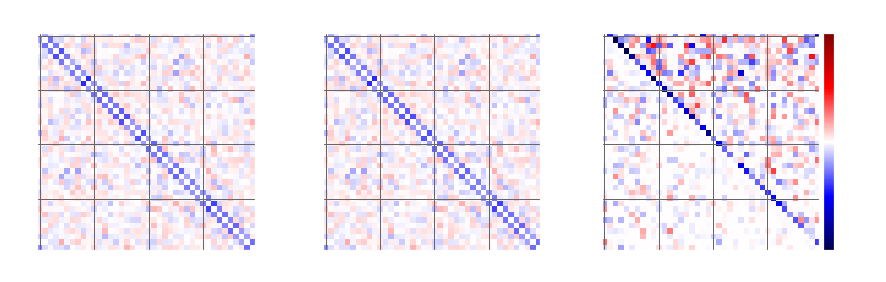

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


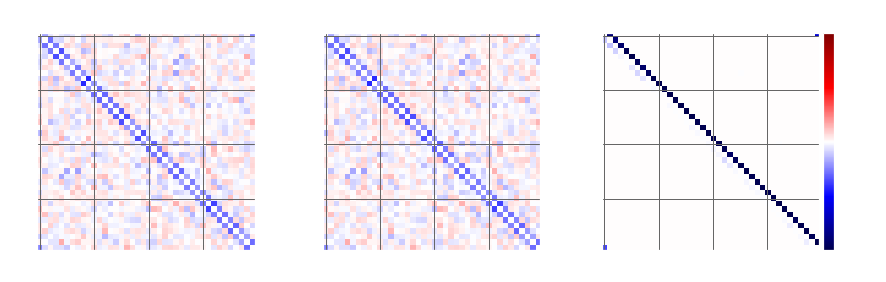

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


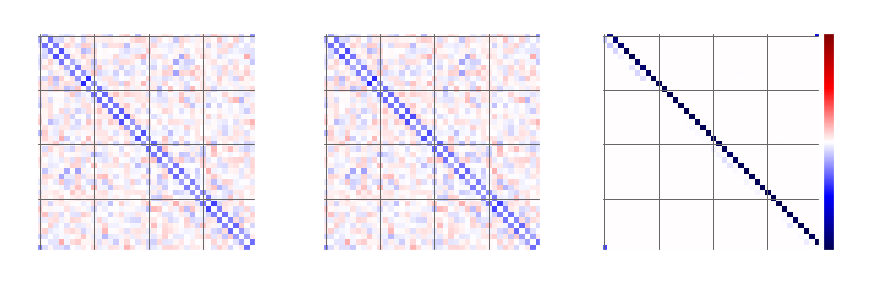

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


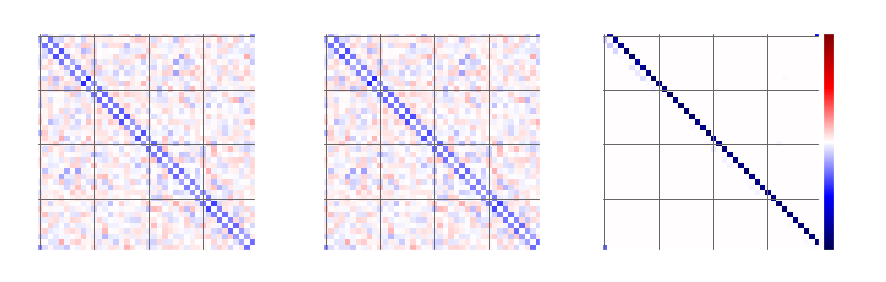

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


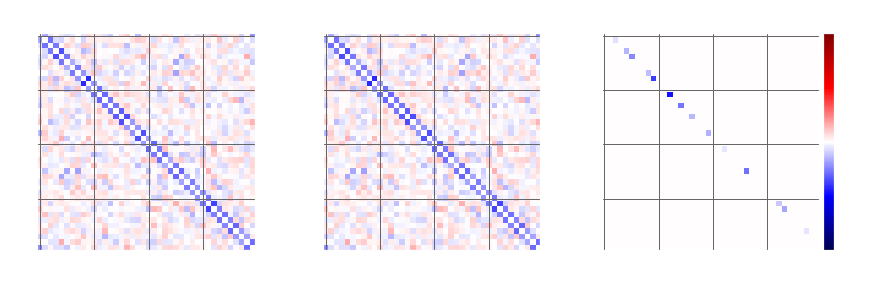

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


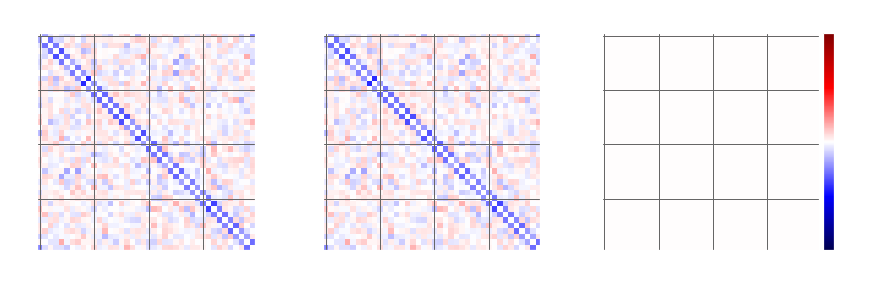

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


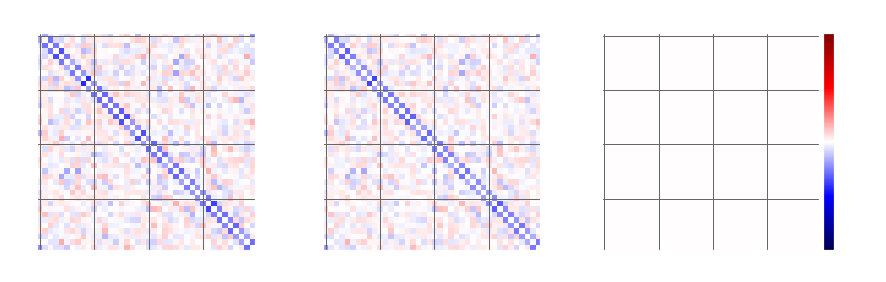

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


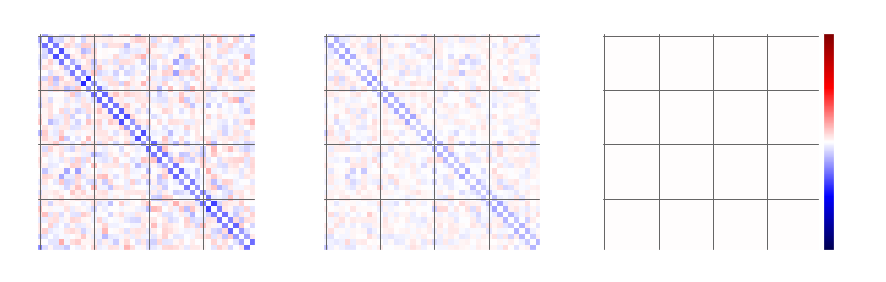

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


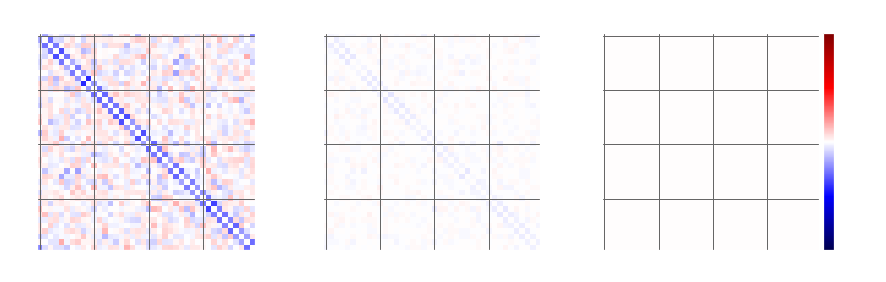

Y_test.shape (200,) leastsq.predict(X_test).shape (200,) X_test.shape (200, 1600)


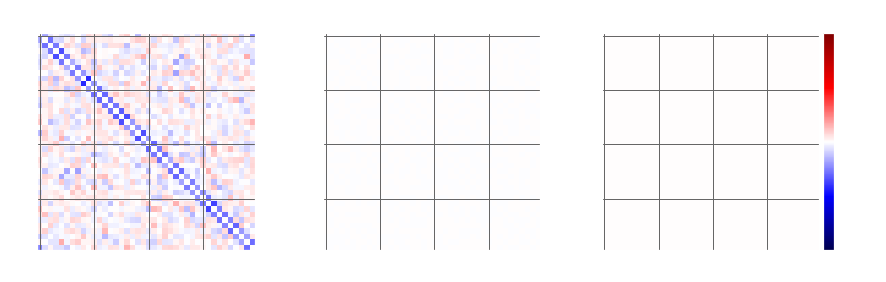

In [4]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
#leastsq=linear_model.LinearRegression()
leastsq=myRegression(X_train, Y_train)
#ridge=linear_model.Ridge()
ridge=myRegression(X_train, Y_train)
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []
train_mse_leastsq = []
test_mse_leastsq = []

train_errors_ridge = []
test_errors_ridge = []
train_mse_ridge = []
test_mse_ridge = []

train_errors_lasso = []
test_errors_lasso = []
train_mse_lasso = []
test_mse_lasso = []

# set refularisations trength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

def r_squared(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - np.mean(y_hat)) ** 2)

for lmbda in lmbdas:
    
    ### OLS
    coeffsLs = leastsq.ols()
    coefs_leastsq.append(coeffsLs) 
    train_errors_leastsq.append(r_squared(Y_train, leastsq.predict(X_train))) 
    test_errors_leastsq.append(r_squared(Y_test, leastsq.predict(X_test)))
    train_mse_leastsq.append(mean_squared_error(Y_train, leastsq.predict(X_train))) 
    test_mse_leastsq.append(mean_squared_error(Y_test, leastsq.predict(X_test)))
    
    ###  Ridge 
    coeffsRidge = ridge.ridge(lmbda)
    coefs_ridge.append(coeffsRidge) 
    train_errors_ridge.append(r_squared(Y_train, ridge.predict(X_train))) 
    test_errors_ridge.append(r_squared(Y_test, ridge.predict(X_test)))
    train_mse_ridge.append(mean_squared_error(Y_train, ridge.predict(X_train)))
    test_mse_ridge.append(mean_squared_error(Y_test, ridge.predict(X_test)))
    
    ###  Lasso 
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))
    train_mse_lasso.append(mean_squared_error(Y_train, lasso.predict(X_train)))
    test_mse_lasso.append(mean_squared_error(Y_test, lasso.predict(X_test)))

    ### plot Ising interaction J
    J_leastsq=np.array(coeffsLs[1:]).reshape((L,L))
    J_ridge=np.array(coeffsRidge[1:]).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

The OLS estimation seems to have largest values along the nearest diagnaol points to the diagonal, which represents the neigboiring spins. It is good that the OLS estimator gives largst coefficients along the these neigbouring diagonals, since the data was created by only neighbouring spins. <br>

The weights equal around -0.5 for Ridge and Lasso. This reflects the fact that each weight takes in two symmetric parts, e.g. $J_{j, j-1}$ and $J_{j, j+1}$ and the weights are distributed equally between these terms. Hence we have -1 on the digiagonal, or more precisely, on the nearest neigbour diagonals to the main diagonal. <mark> Imrpove! See Methta p.25. <br>
    
Finally we get another confirmation that our regression class works well. We observe that the results are very similar to those of notebook4 of Mehta et al. (2018): https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVI-linreg_ising.html. 
    
## Performance


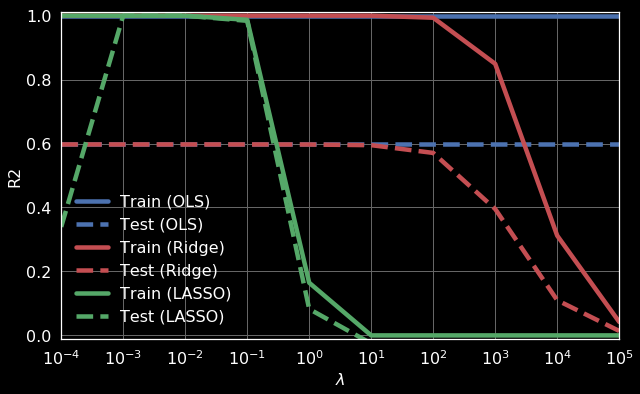

In [6]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('R2',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure x:__ R2 scores. Test and training. All models. Regression. 1D. <br>
_There is a maximum $\lambda$ for both Ridge and Lasso. At some $\lambda$ both the Ridge and the Lasso model starts doing worse._ <br>

Lasso is the model that gives the best fit, since it, for a sufficiently large $\lambda$, is able to remove the insignifican parameters. <br>

The optimal $\lambda$ is around $10^{-2}$ for Lasso and $10$ for Ridge. The optima are found where the test performance peaks. <br>

Lets take a look at the MSEs.

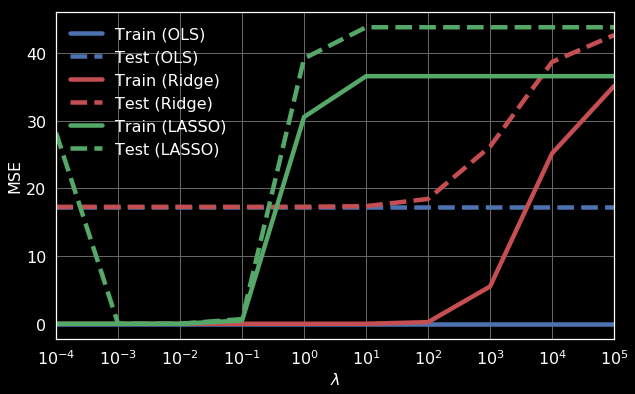

In [7]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_mse_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_mse_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_mse_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_mse_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_mse_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_mse_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper left',fontsize=16)
#plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure X:__ MSE. Test and training. All models. Regression. 1D. <br>
_The story is the same as for the R2-score: There are critical $\lambda$'s for which the test MSE of Ridge and Lasso start to increase. The critical $\lambda$'s are the same as for the R2-score._

## Bias-variance decomposition
From above we have that the shape of the test MSE depends on the regularization. The regularization reflects the complexity of the models. Higher regularization implies that more parameters get lower value, lowering the effective number of parameters in the model, reducing the complexity. <br>

The change in test MSE can come from two sources: Bias and variance. High complexity normally goes hand in hand with low bias and high variance, and the oppsotite for low complexity. Using the bootstrapping method, which is described in project 1, we will now perform a bias-variance decomposition of the above results.

In [8]:
from collections import OrderedDict
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

def bootstrap(xData, yData,  R, lmbda):
    n = xData.shape[0] 
    inds = np.arange(n); 

    mseMatrixUnknownF =  OrderedDict()
    sdMatrixUnknownF =  OrderedDict()
    bias2MatrixUnknownF =  OrderedDict()
    totalMatrixUnknownF =  OrderedDict()
    residualDictUnknownF = OrderedDict()
    
    models = ['ridge', 'lasso']
    
    for i in models:
        mseMatrixUnknownF[i] = np.zeros(n)
        sdMatrixUnknownF[i] = np.zeros(n)
        bias2MatrixUnknownF[i] = np.zeros(n)
        totalMatrixUnknownF[i] = np.zeros(n)
        residualDictUnknownF[i] = OrderedDict()
        for j in range(n):
            residualDictUnknownF[i][j] = []    
                                                                                                                                        
    for i in range(R):
        idxTrain = np.random.randint(0,n,n)
        idxValid = np.setdiff1d(np.union1d(inds, idxTrain ), np.intersect1d(inds, idxTrain))
        
        x_train = xData[idxTrain]
        y_train = yData[idxTrain]
        x_valid = xData[idxValid]
        y_valid = yData[idxValid]
        
        #ridge.set_params(alpha=lmbda) # set regularisation parameter
        #ridge.fit(x_train, y_train) # fit model
        #yPredictRidge = ridge.predict(x_valid)
        ridge.ridge(lmbda)
        yPredictRidge = ridge.predict(x_valid)     

         
        lasso.set_params(alpha=lmbda) # set regularisation parameter
        lasso.fit(x_train, y_train) # fit model
        yPredictLasso = lasso.predict(x_valid)
        
        for i in range(len(idxValid)):
            residualDictUnknownF[models[0]][i].append(y_valid[i] -yPredictRidge[i])
            residualDictUnknownF[models[1]][i].append(y_valid[i] -yPredictLasso[i])
            
    mseUnknownF = OrderedDict()
    sdUnknownF = OrderedDict()
    bias2UnknownF = OrderedDict()
    totalUnknownF = OrderedDict()
        
    for model in models:
        for i in range(n):
            mseMatrixUnknownF[model][i] = np.mean([(residualDictUnknownF[model][i][j])**2 for j in range(len(residualDictUnknownF[model][i]))])#np.mean( (residualDictUnknownF[key])**2 )
            sdMatrixUnknownF[model][i] = np.var( residualDictUnknownF[model][i] )
            bias2MatrixUnknownF[model][i] = ( np.mean(residualDictUnknownF[model][i]) )**2
            totalMatrixUnknownF[model][i] = sdMatrixUnknownF[model][i] + \
    bias2MatrixUnknownF[model][i]
        mseUnknownF[model] = np.nanmean(mseMatrixUnknownF[model])
        sdUnknownF[model] = np.nanmean(sdMatrixUnknownF[model])
        bias2UnknownF[model] = np.nanmean(bias2MatrixUnknownF[model])
        totalUnknownF[model] = np.nanmean(totalMatrixUnknownF[model])
            
    return mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF

#leastsq=linear_model.LinearRegression()
#ridge=linear_model.Ridge()
leastsq=myRegression(X_train, Y_train)
ridge=myRegression(X_train, Y_train)
lasso = linear_model.Lasso()
lmbdas = np.logspace(-4, 5, 10)
R = 50
xData = X_train
yData = Y_train
mses, sds, biases, totals = [], [], [], []
for lmbda in lmbdas:
    mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF = bootstrap(xData, yData,  R, lmbda)   
    mses.append(mseUnknownF)
    sds.append(sdUnknownF)
    biases.append(bias2UnknownF)
    totals.append(totalUnknownF)
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)


In [9]:
msePlot = OrderedDict()
varPlot = OrderedDict()
biasPlot = OrderedDict()
totalPlot = OrderedDict()

models = ['ridge', 'lasso']
for model in models:
    msePlot[model] = []
    varPlot[model] = []
    biasPlot[model] = []
    totalPlot[model] = []


for model in models:
    for i in range(len(mses)):
        msePlot[model].append(mses[i][model])
        varPlot[model].append(sds[i][model])
        biasPlot[model].append(biases[i][model])
        totalPlot[model].append(totals[i][model])

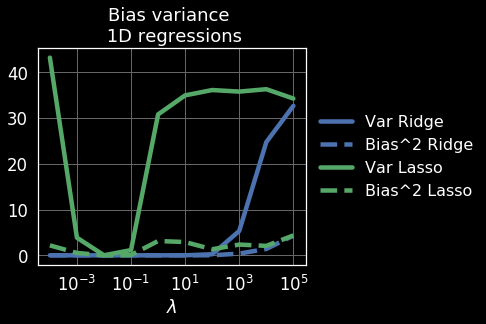

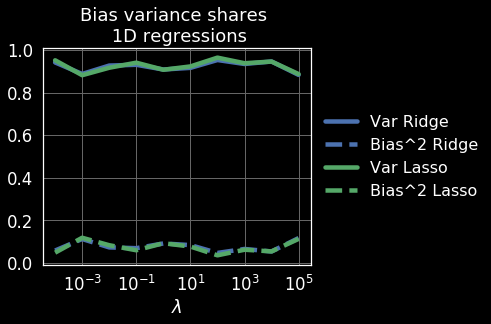

In [18]:
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)
fig, ax = plt.subplots()
ax.semilogx(lmbdas, varPlot[models[0]], 'b',label='Var Ridge')
ax.semilogx(lmbdas, biasPlot[models[0]], '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, varPlot[models[1]], 'g',label='Var Lasso')
ax.semilogx(lmbdas, biasPlot[models[1]], '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()

fig, ax = plt.subplots()
ax.semilogx(lmbdas, np.array(varPlot[models[0]])/np.array(msePlot[models[0]]), 'b',label='Var Ridge')
ax.semilogx(lmbdas, np.array(biasPlot[models[0]])/np.array(msePlot[models[0]]), '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, np.array(varPlot[models[1]])/np.array(msePlot[models[1]]), 'g',label='Var Lasso')
ax.semilogx(lmbdas, np.array(biasPlot[models[1]])/np.array(msePlot[models[1]]), '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance shares \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()

__Figure :__ Bias-variance decomposition. Ridge and Lasso. 1D regression. <br>
_It is increased variance that drives the rise of MSE._ <br>

__Figure :__ Bias-variance decopmososion. Shares of MSE. Ridge and Lasso. 1D regression. <br>
_The shares varies little with $\lambda$. The variance makes up almost 90 per cent of the MSE for both models.

When interpreting the above figure, we must keep in min that the smallest $\lambda$'s are overfitting the models. For Lasso we see that the variance comes down as $\lambda$ is increased from the lowest level. This implies that there was overfitting for the lowst $\lambda$'s. The bias for Lasso is farly constant, reflecting that the average error does not vary much with $\lambda$. When restricting the parameters a lot, the Lasso model again becomes sensitive to the training set used. At $\lambda=10^{-1}$ there is a jump in the variance for Lasso. <br>

For Ridge everything is pretty constant up to $\lambda=10^3$. At $\lambda = 10^{3}$ the variance of Ridge starts to increase, reflecting that Ridge model becomes sensitive to the training data. A small change in training data gives very different models. We had expected also the Ridge model to have a higher variance for the lowest $\lambda$, as Lasso did, since we are overfitting at low levels of $\lambda$. Perhaps even smaller levels of $\lambda$ would be necessary for Ridge to have a higher starting variance.

# Logistic regression

Logistic regression class.

In [7]:
class LogisticRegressionC:
    def __init__(self, xData, yData):
        self.xData, self.yData = xData, yData
        self.features = np.shape(self.xData)[1] 
        
    def createDesignMatrix(self):
        self.XHat = np.c_[np.ones(np.shape(self.xData)[0]), self.xData]
        
    def sigmoid(self, z):
        self.sigmoidOutput = 1./(1. + np.exp(-z))
        
    def gradientDescent(self, iterations = 1000, tolerance = 1e-8, eta=0.1):
        #self.betaHat = np.random.random(self.features + 1) - .5
        self.betaHat = np.random.uniform(low=-.05, high=.05, size=(self.features + 1))

        iteration = 1
        gradient = 10
        while (iteration < iterations and np.linalg.norm(gradient) > tolerance):
            self.sigmoid(self.XHat @ self.betaHat)
            pHat = self.sigmoidOutput            
            gradient = -self.XHat.T @ (self.yData - pHat)# / self.yData.size # Depends if 1/m in cost-f
            self.betaHat -= eta*gradient
            iteration += 1
        print('iteration: ', iteration, '\nnp.linalg.norm(gradient)', np.linalg.norm(gradient))
        cost = self.calculateCost(self.XHat, self.yData)
        print('Cost ', cost)
        
    def stochasticGradientDescent(self,tolerance = 1e-8, n_epochs=50,t0=5, t1 = 50):
        """ From Hjorth-Jensen's ML lecture notes"""
        
        def learning_schedule(t):
            return t0/(t+t1)

        #self.betaHat = np.random.random(self.features + 1) - .5
        self.betaHat = np.random.uniform(low=-.05, high=.05, size=(self.features + 1))
        
        m = len(self.yData)
        cost_history = np.zeros(n_epochs)

        for epoch in range(n_epochs):
            cost = 0
            costBest = 1e9
            for i in range(m):
                random_index = np.random.randint(m)
                xi = self.XHat[random_index:random_index+1]
                yi = self.yData[random_index:random_index+1]
                self.sigmoid(xi @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -xi.T @ (yi - pHat)
                eta = learning_schedule(epoch*m+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(xi,yi)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
                
        return self.betaHat, cost_history, betaBest
            
                
                
    def stochasticGradientDescent2(self, nEpochs=50, batchSize=20,t0=5, t1 = 50):
        """ Modified version of MHJ's version in MHJ's lecture notes """
        
        def learning_schedule(t):
            return t0/(t+t1)
        
        observations = len(self.yData)
        cost_history = np.zeros(nEpochs)
        n_batches = int(observations/batchSize)

        self.betaHat = np.random.random(self.features + 1) - .5
        
        costBest = 1e9
        for epoch in range(nEpochs):
            cost =0.0
            indices = np.random.permutation(observations)
            X = self.xData[indices]
            y = self.yData[indices]
            for i in range(0,observations,batchSize):
                X_i = X[i:i+batchSize]
                y_i = y[i:i+batchSize]
                
                X_i = np.c_[np.ones(len(X_i)),X_i]
                self.sigmoid(X_i @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -X_i.T @ (y_i - pHat)
                eta = learning_schedule(epoch*n_batches+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(X_i,y_i)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
        return self.betaHat, cost_history, betaBest
    
    def calculateCost(self, X, y):
        " Cross entropy"
        term1 = X @ self.betaHat
        term2 = np.log(1 + np.exp(X @ self.betaHat))
        ce = 0
        for i in range(len(y)):
            ce -= (y[i]*term1[i] - term2[i]) 
        return ce
                
            
    def predict(self, X):
        self.xData = X
        self.createDesignMatrix()
        self.sigmoid(self.XHat @ self.betaHat)
        return self.sigmoidOutput
        
        
    def predictHard(self, X, threshold = .5):
        prediction = self.predict(X)
        #self.predict(X)
        #prediction = self.sigmoidOutput
        return prediction >= threshold
    
    
    def bootstrap(self, xData, yData,  R):
        n = xData.shape[0] 
        inds = np.arange(n); 

        mseMatrixUnknownF =  OrderedDict()
        sdMatrixUnknownF =  OrderedDict()
        bias2MatrixUnknownF =  OrderedDict()
        totalMatrixUnknownF =  OrderedDict()
        residualDictUnknownF = OrderedDict()

        mseMatrixUnknownF = np.zeros(n)
        sdMatrixUnknownF = np.zeros(n)
        bias2MatrixUnknownF = np.zeros(n)
        totalMatrixUnknownF = np.zeros(n)
        residualDictUnknownF = OrderedDict()
        for j in range(n):
            residualDictUnknownF[j] = []    

        for i in range(R):
            idxTrain = np.random.randint(0,n,n)
            idxValid = np.setdiff1d(np.union1d(inds, idxTrain ), np.intersect1d(inds, idxTrain))

            x_train = xData[idxTrain]
            y_train = yData[idxTrain]
            x_valid = xData[idxValid]
            y_valid = yData[idxValid]
            
            
            
            self.xData = xData
            self.yData = yData
            self.createDesignMatrix()
            betaHat, cost_history, betaBest = \
            stochasticGradientDescent2(self, nEpochs=50, batchSize=20,t0=5, t1 = 50)
            self.sigmoid(self.XHat @ self.betaHat)

            for i in range(len(idxValid)):
                residualDictUnknownF[i].append(y_valid[i] -self.sigmoidOutput[i])

        mseUnknownF = OrderedDict()
        sdUnknownF = OrderedDict()
        bias2UnknownF = OrderedDict()
        totalUnknownF = OrderedDict()

        for i in range(n):
            mseMatrixUnknownF[i] = np.mean([(residualDictUnknownF[j])**2 for j in range(len(residualDictUnknownF[model][i]))])#np.mean( (residualDictUnknownF[key])**2 )
            sdMatrixUnknownF[i] = np.var( residualDictUnknownF[i] )
            bias2MatrixUnknownF[i] = ( np.mean(residualDictUnknownF[i]) )**2
            totalMatrixUnknownF[i] = sdMatrixUnknownF[i] + \
        bias2MatrixUnknownF[i]
        mseUnknownF = np.nanmean(mseMatrixUnknownF)
        sdUnknownF = np.nanmean(sdMatrixUnknownF)
        bias2UnknownF = np.nanmean(bias2MatrixUnknownF)
        totalUnknownF = np.nanmean(totalMatrixUnknownF)

        return mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF
'''
np.random.seed(1)
xdata = np.random.randint(10, size=(4,2))
ydata = np.random.randint(10, size=4)

lr = LogisticRegressionC(xdata, ydata)
lr.createDesignMatrix()
lr.XHat
#print(lr.XHat)
lr.gradientDescent(iterations=100)
lr.betaHat

xNew = np.random.randint(3, size=(3,2))
lr.xData = xNew
lr.createDesignMatrix()

lr.predict()
lr.predict
'''

'\nnp.random.seed(1)\nxdata = np.random.randint(10, size=(4,2))\nydata = np.random.randint(10, size=4)\n\nlr = LogisticRegressionC(xdata, ydata)\nlr.createDesignMatrix()\nlr.XHat\n#print(lr.XHat)\nlr.gradientDescent(iterations=100)\nlr.betaHat\n\nxNew = np.random.randint(3, size=(3,2))\nlr.xData = xNew\nlr.createDesignMatrix()\n\nlr.predict()\nlr.predict\n'

Importing data

In [3]:
import pickle,os
import numpy as np

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# path to data directory
cwd = os.getcwd()
path_to_data=cwd + '/IsingData/'#os.path.expanduser('~')+'IsingData/'

# load data
file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

The above gives memory error further down the way.

Try stacking

In [5]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import os


def read_t(t=0.25,root="./"):
    if t > 0.:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    else:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    #data = np.unpackbits(data).astype(int).reshape(-1,1600)
    data = np.int8(np.unpackbits(data).reshape(-1,1600))
    data[np.where(data==0)]=-1
    return data

cwd = os.getcwd()
root=cwd + '/IsingData/'#os.path.expanduser('~')+'IsingData/'
stack = []
labels = np.zeros((10000*13))
#labels = np.zeros((10000*11))
counter = 0
for t in .25, .5, .75, 1., 1.25, 1.5, 1.75, 2.75, 3., 3.25, 3.5, 3.75, 4.0:#np.arange(0.25,4.01,0.25):
#for t in .5, .75, 1., 1.25, 1.5, 1.75, 2.75, 3., 3.25, 3.5, 3.75:
    stack.append(read_t(t, root=root))
    y = np.ones(10000,dtype=int)
    if t > 2.25:
        y*=0

    labels[counter*10000:(counter+1)*10000] = y
    counter += 1
data = np.vstack(stack)
del stack

num_classes=2
train_to_test_ratio=0.5 # training samples
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio, \
                                              test_size = 1-train_to_test_ratio)

## Mehta's calculations, Sci-Kit learn

In [9]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    print('accuracy: train, test')
    print('SGD: %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

accuracy: train, test
SGD: 0.4920, 0.4720
finished computing 1/11 iterations


KeyboardInterrupt: 

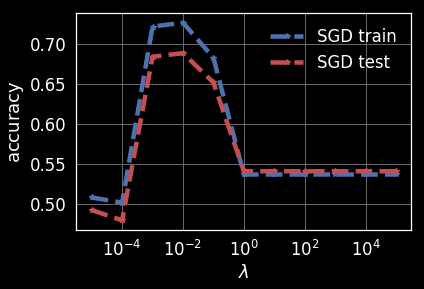

In [8]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

#plt.grid()
plt.legend()


plt.show()

### My class
Now we will analyse the same data as we did above with Sci-Kit learn, but now with our newly developed logistic regression class. <br>

The solution does not apply an exact expression, as e.g. OLS, so we must rely on iterative methods. In our class we have developed three different methods for minimizing the cost function: Standard gradient descent, stochastic gradient descent and mini-batch gradient descent. We will now compare these three methods by applying them in the logistic regression on the phase data.

In [8]:
# My class

lr2 = LogisticRegressionC(X_train,Y_train)
lr2.createDesignMatrix()


# Mini-batch stochastic gradient descent
betaMB, costMB, betaBestMB = lr2.stochasticGradientDescent2(nEpochs=50, batchSize=20,t0=5, t1 = 25)
myPredictHardTrain = lr2.predictHard(X_train)
accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
print('Accuracy mini-batch, train', accuracyMyModelTrain)
myPredictHardTest = lr2.predictHard(X_test)
accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
print('Accuracy mini-batch, test', accuracyMyModelTest)
print('Best cost: ', np.min(costMB))

# Gradient descent
lr2.gradientDescent(iterations=1000,tolerance = 1e-20, eta=0.1)
myPredictHardTrain = lr2.predictHard(X_train)
accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
print('\nAccuracy Gradient descent, train', accuracyMyModelTrain)
myPredictHardTest = lr2.predictHard(X_test)
accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
print('Accuracy Gradient descent, test', accuracyMyModelTest)

# Stochastic gradient descent
betaS, costS, betaBestS = lr2.stochasticGradientDescent( tolerance = 1e-8, n_epochs=1000,t0=5, t1 = 50)
myPredictHardTrain = lr2.predictHard(X_train)
accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
print('\nAccuracy Stochastic gradient descent, train', accuracyMyModelTrain)
myPredictHardTest = lr2.predictHard(X_test)
accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
print('Accuracy Stochastic gradient descent, test', accuracyMyModelTest)
print('Best cost: ', np.min(costS))

'''
from sklearn.metrics import accuracy_score
print('My class Accuracy train: ', accuracy_score(Y_train, myPredictHardTrain))
print('My class Accuracy test: ', accuracy_score(Y_test, myPredictHardTest))
'''

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in exp
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Accuracy mini-batch, train 0.7275384615384616
Accuracy mini-batch, test 0.6876153846153846
Best cost:  43433.44980798421
iteration:  1000 
np.linalg.norm(gradient) 725448.8734329732
Cost  inf

Accuracy Gradient descent, train 0.45603076923076924
Accuracy Gradient descent, test 0.4579692307692308


KeyboardInterrupt: 

First we see that accuracies for mini-batch are about the same as the best accuracies found by Mehta. <br>

The rankings of the methods from best to worst are: mini-batch, stochastic gradient descent and standard gradient descent. The accuracies of the standard gradient descent are below 0.5. The stochastic gradient descent does considerably better than the standard gradient descent and is closer in performance to the mini-batch method. <br> 

The difference between the stochastic and the mini-batch method is also reflected in the lowest cost values calculated during simukations. The minimum cost is much higher for the stochastic method than for the mini-batch method.<br>

For the mini-batch method, there is a notable distance between the training and test set performance. The test accuracy is around three percentage points lower compared to the training accuracy. For the standard and the stochastic gradient descent, on the other hand, there are practically no differences between training and test set performance. <br>

# NN

In [207]:
class NeuralNetwork:
    """
    Based on the lecture notes of Morten Hjorth-Jensen.
    https://compphysics.github.io/MachineLearning/doc/pub/NeuralNet/html/NeuralNet.html
    """
    def __init__(
        self,
        X_data,
        Y_data,
        n_hidden_neurons=50,
        n_categories=10,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
        activationFunctionHidden='sigmoid',
        activationFunctionOutput='linear'
    ):
        
        
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        if X_data.ndim == 1:
            self.n_features = 1
        else:
            self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        if activationFunctionHidden=='sigmoid':
            self.activationFunctionHidden = self.sigmoid
            self.derivativeHidden = self.sigmoidDerivative

        if activationFunctionHidden=='relu':
            self.activationFunctionHidden = self.relu
            self.derivativeHidden = self.reluDerivative

        
        if activationFunctionOutput == 'linear':
            self.activationFunctionOutput = self.linear
            self.derivativeOutput = self.linearDerivative
    
        if activationFunctionOutput == 'sigmoid':
            self.activationFunctionOutput = self.sigmoid
            self.derivativeOutput = self.sigmoidDerivative
            
        if activationFunctionOutput == 'softMax':
            self.activationFunctionOutput = self.softMax
        

        self.create_biases_and_weights()
        
    def sigmoid(self, z):
        return 1./(1 + np.exp(-z))
    
    def sigmoidDerivative(self, z):
        return self.sigmoid(z)*(1. - self.sigmoid(z))
    
    def linear(self, z):
        return z
    
    def linearDerivative(self, z):
        return 1
    
    def softMax(self, z_o):
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities
    
    def relu(self, x):
        return x * (x > 0)

    def reluDerivative(self, x):
        return 1. * (x > 0)

    def create_biases_and_weights(self):
        #self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        #self.hidden_weights = np.random.uniform(low=-.05, high=.05, size=(self.n_features, self.n_hidden_neurons))
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)*np.sqrt(2./self.n_features)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) #+ 0.01

        #self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        #self.output_weights  = np.random.uniform(low=-.05, high=.05, size=(self.n_hidden_neurons, self.n_categories))
        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)*np.sqrt(2./self.n_hidden_neurons)

        self.output_bias = np.zeros(self.n_categories) #+ 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = self.activationFunctionHidden(self.z_h) # changed

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        #exp_term = np.exp(self.z_o)
        #self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        self.a_o = self.activationFunctionOutput(self.z_o)# Changed
        
    def feed_forward_out(self, X):
        # feed-forward for output
        if X.ndim == 1:
            X = X.reshape(-1,1)
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = self.activationFunctionHidden(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        a_o = self.activationFunctionOutput(z_o)# Changed
        return a_o
        #exp_term = np.exp(z_o)
        #probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        #return probabilities
        
        

    def backpropagation(self):
        #error_output = (self.z_o - self.Y_data)#*self.derivativeOutput(self.z_o) # changed
        #error_output = self.probabilities - self.Y_data

        error_output = self.a_o - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.derivativeHidden(self.z_h)#* self.a_h * (1 - self.a_h) # changed

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        if self.activationFunctionOutput != self.linear:
            return np.argmax(probabilities, axis=1)
        else:
            return probabilities
    

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            #data_indices = np.random.permutation(self.n_inputs) # Based on keras documentation
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                if self.X_data.ndim == 1:
                    self.X_data = self.X_data.reshape(-1,1)
                
                if self.Y_data.ndim == 1:
                    self.Y_data = self.Y_data.reshape(-1,1)
                    

                self.feed_forward()
                self.backpropagation()
                
    def train2(self):
        """
        MHJ's train + my grad descent2. 
        Differences: -where randomization takes place: Each epoch or each batch
                     - endogenuous learning rate
        """
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            #for j in range(self.iterations):
            indices = np.random.permutation(self.n_inputs)
            X = self.X_data_full[indices]
            y = self.Y_data_full[indices]
            for j in range(0, self.n_inputs, self.batch_size):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = X[j:j+self.batch_size] #self.X_data_full[chosen_datapoints]
                self.Y_data = y[j:j+self.batch_size] #self.Y_data_full[chosen_datapoints]
                
                if self.X_data.ndim == 1:
                    self.X_data = self.X_data.reshape(-1,1)
                
                if self.Y_data.ndim == 1:
                    self.Y_data = self.Y_data.reshape(-1,1)
                    
                def learning_schedule(t, t0=5, t1=50):
                    return t0/(t+t1)
                
                self.eta = learning_schedule(i*self.iterations+j)

                self.feed_forward()
                self.backpropagation()
                
    def stochasticGradientDescent2(self, nEpochs=50, batchSize=20,t0=5, t1 = 50):
        """ Modified version of MHJ's version in MHJ's lecture notes """
        
        def learning_schedule(t):
            return t0/(t+t1)
        
        observations = len(self.yData)
        cost_history = np.zeros(nEpochs)
        n_batches = int(observations/batchSize)

        self.betaHat = np.random.random(self.features + 1) - .5
        
        costBest = 1e9
        for epoch in range(nEpochs):
            cost =0.0
            indices = np.random.permutation(observations)
            X = self.xData[indices]
            y = self.yData[indices]
            for i in range(0,observations,batchSize):
                X_i = X[i:i+batchSize]
                y_i = y[i:i+batchSize]
                
                X_i = np.c_[np.ones(len(X_i)),X_i]
                self.sigmoid(X_i @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -X_i.T @ (y_i - pHat)
                eta = learning_schedule(epoch*n_batches+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(X_i,y_i)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
        return self.betaHat, cost_history, betaBest

# NN classification

In [12]:
# Running class
def to_categorical_numpy(integer_vector):
    print(type(integer_vector))
    n_inputs = len(integer_vector)
    n_categories = int(np.max(integer_vector)) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

from  tensorflow.keras.utils import to_categorical
Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
#Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)


epochs = 100
batch_size = 30
eta = 0.01
lmbd = 0.#0.01
n_hidden_neurons = 50
n_categories = 2
activationFunctionHidden='sigmoid'
activationFunctionOutput='softMax'

dnn = NeuralNetwork(X_train,Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories, 
                   activationFunctionHidden=activationFunctionHidden, activationFunctionOutput=activationFunctionOutput)
dnn.train()
train_predict = dnn.predict(X_train)
test_predict = dnn.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy score on training set: ", accuracy_score(Y_train, train_predict))
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

Accuracy score on test set:  0.946


Accuracy score on training set:  0.9988307692307692


### NN Ising Keras

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', input_dim=X_train.shape[1]))#128 neumberof neurans in the present layer
model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train,
                    Y_train_onehot, 
	epochs=100, 
	batch_size=30,
	validation_data=[X_test, Y_test_onehot])#Y_test

#print('accuracy', model.evaluate(X_test, y_test))
plt.plot(history.history['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                80050     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 80,152
Trainable params: 80,152
Non-trainable params: 0
_________________________________________________________________
None
Train on 65000 samples, validate on 65000 samples
Epoch 1/100
65000/65000 [==============================] - 7s 102us/step - loss: 0.0138 - acc: 0.9978 - val_loss: 0.0047 - val_acc: 0.9993
Epoch 2/100
65000/65000 [==============================] - 6s 97us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0027 - val_acc: 0.9995
Epoch 3/100
65000/65000 [==============================] - 6s 99us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0020 - val_acc: 0.9996
Epoch 4/100
65000/65000 [==============================] - 6s 99

65000/65000 [==============================] - 6s 97us/step - loss: 5.6761e-05 - acc: 1.0000 - val_loss: 2.2547e-04 - val_acc: 1.0000
Epoch 53/100
65000/65000 [==============================] - 6s 97us/step - loss: 5.5588e-05 - acc: 1.0000 - val_loss: 2.2088e-04 - val_acc: 1.0000
Epoch 54/100
65000/65000 [==============================] - 7s 101us/step - loss: 5.4442e-05 - acc: 1.0000 - val_loss: 2.1945e-04 - val_acc: 1.0000
Epoch 55/100
65000/65000 [==============================] - 6s 90us/step - loss: 5.3357e-05 - acc: 1.0000 - val_loss: 2.1721e-04 - val_acc: 1.0000
Epoch 56/100
65000/65000 [==============================] - 6s 92us/step - loss: 5.2298e-05 - acc: 1.0000 - val_loss: 2.1297e-04 - val_acc: 1.0000
Epoch 57/100
65000/65000 [==============================] - 6s 98us/step - loss: 5.1270e-05 - acc: 1.0000 - val_loss: 2.0935e-04 - val_acc: 1.0000
Epoch 58/100
65000/65000 [==============================] - 6s 93us/step - loss: 5.0307e-05 - acc: 1.0000 - val_loss: 2.0886e-04 -

KeyError: 'accuracy'

# NN Regression Ising

In [209]:
epochs = 100#100
batch_size = 32
eta = 0.001
lmbd =  0.0#
n_hidden_neurons = 128
n_categories = 1
activationFunctionHidden='relu' #'sigmoid'
activationFunctionOutput='linear'

dnn = NeuralNetwork(X_train, Y_train, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories, 
                   activationFunctionHidden=activationFunctionHidden, activationFunctionOutput=activationFunctionOutput)
dnn.train()
#dnn.train2()
test_predict = dnn.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print('Y_test.shape, test_predict.shape',Y_test.shape, test_predict.shape)
print('Y_test, test_predict \n',Y_test, '\n', test_predict)

mseNN = mean_squared_error(Y_test, test_predict)
r2NN = r2_score(Y_test, test_predict)

print('Regression. NN. MSE: ', mseNN)
print('Regression. NN. R2: ', r2NN)
print('dnn.output_weights_gradient',dnn.output_weights_gradient)

Y_test.shape, test_predict.shape (200,) (200, 1)
Y_test, test_predict 
 [ -4.   0.  -8.  20.  -8.   0.  -4.   0.   8.   4.  12.  -4.   0.   0.
   0.   8.   0.  -8.   4.   0.  -4.   4.   0.   0.  -4.  -4.   0.  -4.
  -8.   0.   4.   0.   0.   0.   0.  -8.   0.   4.  -4.   4.  -8.   8.
   0.  -4.  12.  -8.  12.  -8. -12.  -8.  -4.  -4.  -8.  12.   8.   4.
   0.   0.  -4.   0.   8. -12.   0.   4.   8.   0.  -4.  -4.   4.  -8.
  -8.  16.   0.  -4. -16.   4.   8.  -8.  -4.  -4.   4.   0.  -4.   4.
 -12.   4.  -8. -12.  -4.  -8.   0.   0.  -8.  -4.   4.   4.   0.  -8.
   4.   4.  -8.  12.  -4.  -4.   4.   0.  -4. -12. -16.  12.  -4.   0.
 -20.   0.  -8.  -4.  -4.   4.  -8.   0.  -8.   0.   0.   0.  -4.  -4.
  -4.   0.   0.   4.  -4. -16.   0.   4.   0.  -4.   0.   4.   4.   4.
   0.  -4. -20.   0.  -4.   8.   4.   0.   4.   0.   4.  12.   0.  -4.
   8.   0.   0.   0.   0.  -4. -16.  -8.  12.   4.   8.   4.   8.   0.
   0.   4.  -4.   0.  -8.  -4.  -8.  12. -12.   0.   0.   4.   4.   4.
   0.

### Keras regression Ising

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 205,057
Trainable params: 205,057
Non-trainable params: 0
_________________________________________________________________
None
Train on 400 samples, validate on 200 samples
Epoch 1/100
400/400 [==============================] - 0s 522us/step - loss: 35.1038 - mean_squared_error: 35.1038 - val_loss: 30.3692 - val_mean_squared_error: 30.3692
Epoch 2/100
400/400 [==============================] - 0s 103us/step - loss: 5.8296 - mean_squared_error: 5.8296 - val_loss: 26.8234 - val_mean_squared_error: 26.8234
Epoch 3/100
400/400 [==============================] - 0s 124us/step - loss: 0.8665 - mean_squared_error: 0.8665 - val_loss: 26.8942 - val_mean_s

400/400 [==============================] - 0s 102us/step - loss: 1.2448e-13 - mean_squared_error: 1.2448e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 45/100
400/400 [==============================] - 0s 106us/step - loss: 1.1499e-13 - mean_squared_error: 1.1499e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 46/100
400/400 [==============================] - 0s 110us/step - loss: 1.1146e-13 - mean_squared_error: 1.1146e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 47/100
400/400 [==============================] - 0s 112us/step - loss: 1.1094e-13 - mean_squared_error: 1.1094e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 48/100
400/400 [==============================] - 0s 101us/step - loss: 1.0208e-13 - mean_squared_error: 1.0208e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 49/100
400/400 [==============================] - 0s 114us/step - loss: 9.2701e-14 - mean_squared_error: 9.2701e-14 - val_loss:

400/400 [==============================] - 0s 100us/step - loss: 7.9912e-14 - mean_squared_error: 7.9912e-14 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 91/100
400/400 [==============================] - 0s 102us/step - loss: 8.7349e-14 - mean_squared_error: 8.7349e-14 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 92/100
400/400 [==============================] - 0s 104us/step - loss: 8.5057e-14 - mean_squared_error: 8.5057e-14 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 93/100
400/400 [==============================] - 0s 101us/step - loss: 1.0214e-13 - mean_squared_error: 1.0214e-13 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 94/100
400/400 [==============================] - 0s 110us/step - loss: 9.2276e-14 - mean_squared_error: 9.2276e-14 - val_loss: 26.7092 - val_mean_squared_error: 26.7092
Epoch 95/100
400/400 [==============================] - 0s 103us/step - loss: 9.8225e-14 - mean_squared_error: 9.8225e-14 - val_loss:

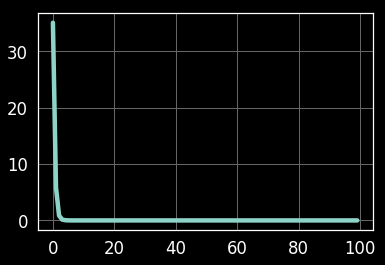

In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))#128 neumberof neurans in the present layer
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
print(model.summary())

history = model.fit(X_train, 
	Y_train, 
	epochs=100, 
	batch_size=32,
	validation_data=[X_test, Y_test])



#print('accuracy', model.evaluate(X_test, y_test))
plt.plot(history.history['mean_squared_error'])

ynew = model.predict(X_train)
print(ynew)

In [154]:
np.random.seed(1)
data_indices = np.array((5,4,1,2,3,7,6, 8))
for i in range(8):
    a = np.random.choice(
                    data_indices, size=2, replace=False)
    print(a)
b = np.random.randn(10, 4)
print(b)
print(b.shape)
sampl = np.random.uniform(low=-0.7, high=0.7, size=(10,4))
print(sampl)
print(sampl.shape)

[8 1]
[1 2]
[2 5]
[7 6]
[6 5]
[1 5]
[2 1]
[6 3]
[[ 0.53381091 -0.0919733   1.91382039  0.33079713]
 [ 1.14194252 -1.12959516 -0.85005238  0.96082   ]
 [-0.21741818  0.15851488  0.87341823 -0.11138337]
 [-1.03803876 -1.00947983 -1.05825656  0.65628408]
 [-0.06249159 -1.73865429  0.103163   -0.62166685]
 [ 0.27571804 -1.09067489 -0.60998525  0.30641238]
 [ 1.69182613 -0.74795374 -0.58079722 -0.11075397]
 [ 2.04202875  0.44752069  0.68338423  0.02288597]
 [ 0.85723427  0.18393058 -0.41611158  1.25005005]
 [ 1.24829979 -0.75767414  0.58829416  0.34685933]]
(10, 4)
[[ 0.17314109  0.35131941 -0.21154232 -0.32210095]
 [ 0.55424071 -0.10067233  0.65077607  0.2288181 ]
 [ 0.17037401 -0.53935564  0.62928496 -0.07012301]
 [ 0.10974546 -0.12860848 -0.36816223  0.56473133]
 [ 0.10315128 -0.69598154  0.16400288 -0.24269714]
 [ 0.03788134  0.54031894 -0.19982234  0.57194921]
 [ 0.17270416 -0.67785026  0.60121213  0.26725568]
 [ 0.69625199 -0.45872329 -0.50800995  0.60563365]
 [ 0.27554543 -0.60759976

# References
Mehta, P., Wang, C.-H., Day, A., and Richardson, C. (2018). A high-bias, low-variance introduction to Machine Learning for physicists. <br> 
https://arxiv.org/pdf/1803.08823.pdf